## 시계열 모델링

### 1. SMA(Simple Moving Average)
    - 특정 기간동안 데이터의 평균을 구해서 기존에 없던 1기 앞의 데이터도 예측 가능함.
    - window size가 길어지면 missing data가 많아지고, trend를 놓치는 경향 있음. 극단값을 반영 X
    
### 2. WMA(Weighted Moving Average)
    - 최근 데이터에 가중치를 높게 주고 최근과 먼 데이터 일수록 가중치 줄임
    - window size에서 lagging 값에 가중치 구해서 평균을 냄

### 3. SES(Simple Exponential Smoothing)
    - Ft+1=Ft+a(At+Ft) : t+1시점에서 At(t시점의 실제값),Ft(t시점의 예측값)을 알 수 있음. 
    그 잔차에 a만큼 가중치를 곱해서 t기 예측값에 더하면 t+1기의 예측값(0<=a<=1)
    - Ft+1=aAt+(1-a)Ft로 다시 쓸 수 있음
    - trend와 seasonality를 반영 X
    - 홀트-윈터스 모델로 trend와 seasonality를 반영

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
airline=pd.read_csv("data/AirPassengers.csv",index_col="Month")

#### 1. SMA(Simple Moving Average)

In [54]:
airline['6 Month SMA']=airline['#Passengers'].rolling(window=6).mean()
airline['12 Month SMA']=airline['#Passengers'].rolling(window=12).mean()

C:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Month'>

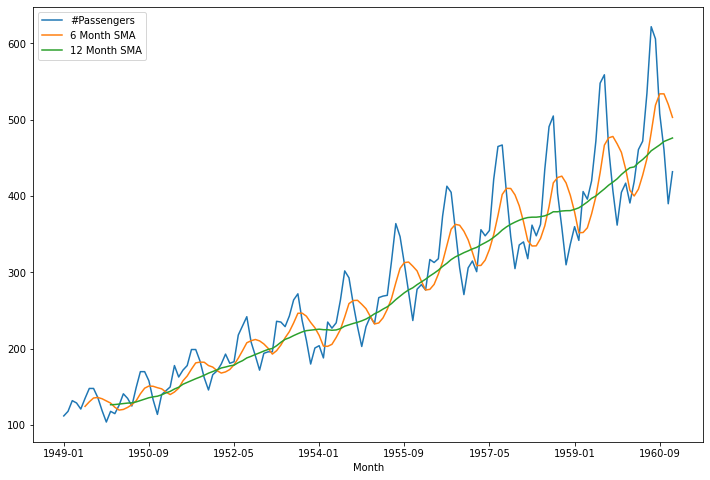

In [55]:
airline.plot(figsize=(12,8))

In [56]:
# 예측값 
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(airline['#Passengers'][5:],airline['6 Month SMA'].dropna()))
rmse

45.73551148059554

#### 2. WMA(Weighted Moving Average)

C:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Month'>

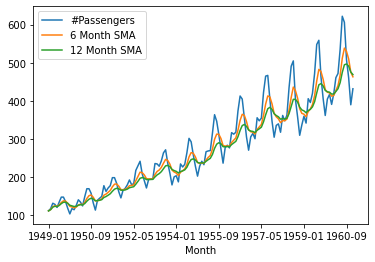

In [57]:
# ewm : exponential weighted moving. 최적의 weight를 알아서 부여
airline['6 Month SMA']=airline['#Passengers'].ewm(span=6).mean()
airline['12 Month SMA']=airline['#Passengers'].ewm(span=12).mean()

airline
airline.plot()
# 좀 더 뾰족하고 12개월 그래프도 원래 데이터의 고저를 잘 따라감

#### 3. SES(Simple Exponential Smoothing, Holt's,Holt's-Winter's )
    - SES : 트렌드와 시즈널 반영X
    -  Holt's : 트렌드 반영
    - Holt's-Winter's : 트렌드와 시즈널 모두 반영

In [70]:
# SES
from statsmodels.tsa.api import SimpleExpSmoothing

In [71]:
# 셋 구분
train=airline[:'1959']
test=airline['1960':]

C:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Month'>

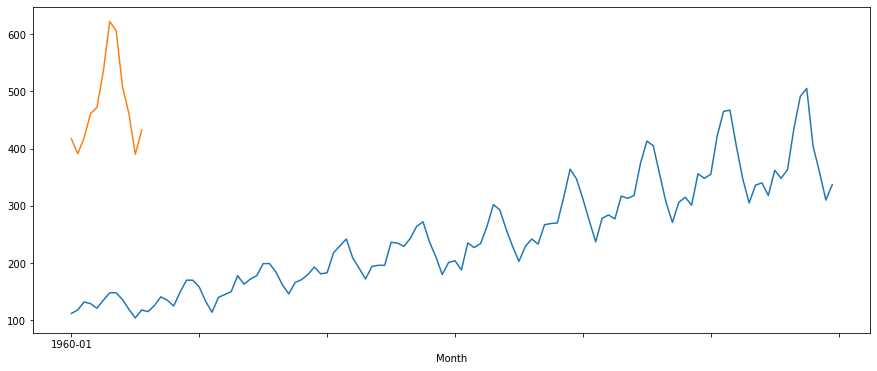

In [72]:
train["#Passengers"].plot(figsize=(15,6))
test["#Passengers"].plot()

In [91]:
# 모델링
ses_model=SimpleExpSmoothing(np.array(train["#Passengers"]))
# 학습 시키기
ses_result=ses_model.fit()
# 예측결과를 테스트 데이터 길이만큼 뽑기
ses_result.forecast(len(test))
# test데이터 뽑기
y_hat=test.copy()
y_hat["SES"]=ses_result.forecast(len(test))

C:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


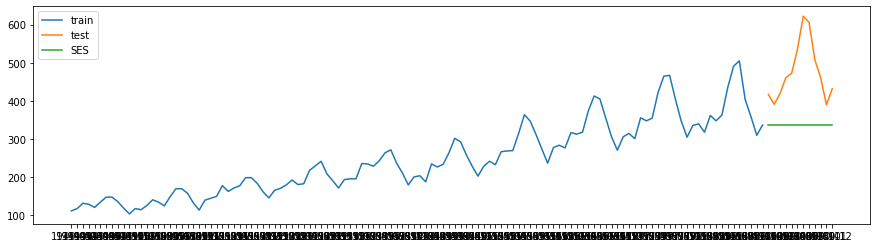

In [93]:
plt.figure(figsize=(15,4))
plt.plot(train["#Passengers"],label="train")
plt.plot(test["#Passengers"],label="test")
plt.plot(y_hat["SES"],label="SES")
plt.legend()
# 트렌드와 시즈널이 반영되지 않았고 SES는 대략 이정도 수준일 것이라고만 표시

In [75]:
rmse=np.sqrt(mean_squared_error(test["#Passengers"],y_hat["SES"]))
rmse

157.8189894956691

In [82]:
# Holt's
from statsmodels.tsa.api import Holt

In [87]:
# 모델링
holt_model=Holt(np.array(train["#Passengers"]))
# 학습 시키기
holt_result=holt_model.fit()
# 예측결과를 테스트 데이터 길이만큼 뽑기
holt_result.forecast(len(test))
# test데이터 뽑기
y_hat=test.copy()
y_hat["Holt"]=holt_result.forecast(len(test))

C:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


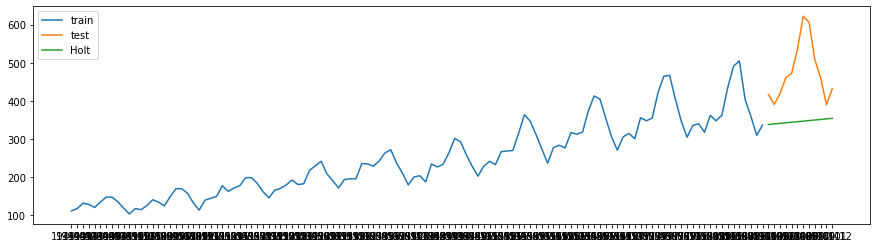

In [88]:
plt.figure(figsize=(15,4))
plt.plot(train["#Passengers"],label="train")
plt.plot(test["#Passengers"],label="test")
plt.plot(y_hat["Holt"],label="Holt")
plt.legend()
# 트렌드와 시즈널이 반영되지 않았고 SES는 대략 이정도 수준일 것이라고만 표시

In [89]:
rmse=np.sqrt(mean_squared_error(test["#Passengers"],y_hat["Holt"]))
rmse

149.1884117418285

In [94]:
# Holt's-Winters
from statsmodels.tsa.api import ExponentialSmoothing

In [102]:
# 모델링
winter_model=ExponentialSmoothing(np.array(train["#Passengers"]),
                                 seasonal_periods=12,
                                 trend="mul",
                                 seasonal="mul")
# add:additive 모델, mul : multiple 모델

# 학습 시키기
winter_result=winter_model.fit()
# 예측결과를 테스트 데이터 길이만큼 뽑기
winter_result.forecast(len(test))
# test데이터 뽑기
y_hat=test.copy()
y_hat["Winter"]=winter_result.forecast(len(test))

C:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [1]:
plt.figure(figsize=(15,6))
plt.plot(train["#Passengers"],label="train")
plt.plot(test["#Passengers"],label="test")
plt.plot(y_hat["Winter"],label="Winter")
plt.legend()
# 트렌드와 시즈널이 반영되지 않았고 SES는 대략 이정도 수준일 것이라고만 표시

NameError: name 'plt' is not defined

In [104]:
# 타 모델 대비 에러 가장 낮음
rmse=np.sqrt(mean_squared_error(test["#Passengers"],y_hat["Winters"]))
rmse

58.16571288273072